Notes:
    
Bleu score increases close to 0.18 when we use a larger reference set.

In [303]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from nltk.translate.bleu_score import corpus_bleu
import os
import pandas as pd
import pickle
from PIL import Image
import sys

import torch
from torchvision import transforms

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sapir_image_captions import GLOBAL_TOKENS, SOS_TOKEN, EOS_TOKEN, PAD_TOKEN
from sapir_image_captions.checkpoints import load_checkpoint
from sapir_image_captions.multi_30k.dataset import CaptionTask2Dataset
from sapir_image_captions.models import batch_beam_search_caption_generation
from sapir_image_captions.utils import text2tensor, tensor2text, remove_tokens

In [7]:
data_dir = "/Users/benpeloquin/Data/general/multi30k/"
images_dir = os.path.join(data_dir, "flickr30k-images/")

In [8]:
en_model_dir_path = "/Users/benpeloquin/Data/projects/sapir_image_captions/trained_models/20190507-ic-en-1"
de_model_dir_path = "/Users/benpeloquin/Data/projects/sapir_image_captions/trained_models/20190507-ic-de-1"

In [144]:
encoder1, decoder1, vocab1, checkpoint1 = load_checkpoint(en_model_dir_path)
encoder1.eval()
decoder1.eval()

encoder2, decoder2, vocab2, checkpoint2 = load_checkpoint(de_model_dir_path)
encoder2.eval()
decoder2.eval()

INFO:root:
    Loading best model -->
        Epoch:	14
        train loss:	7.089632889846276

        dev loss:	7.491584023545244

        test loss:	7.420276763916015

    
INFO:root:
    Loading best model -->
        Epoch:	9
        train loss:	7.291987288639463

        dev loss:	8.439986368137939

        test loss:	8.411923553466798

    


CaptionAttentionDecoder(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_att): Linear(in_features=256, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax()
  )
  (embedding): Embedding(13455, 256)
  (dropout): Dropout(p=0.5)
  (decode_step): LSTMCell(2304, 256)
  (init_h): Linear(in_features=2048, out_features=256, bias=True)
  (init_c): Linear(in_features=2048, out_features=256, bias=True)
  (f_beta): Linear(in_features=256, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=256, out_features=13455, bias=True)
)

In [145]:
hyper_params = vars(checkpoint1['cmd_line_args'])

In [146]:
test_dataset1 = \
        CaptionTask2Dataset(data_dir, "test", year=hyper_params['year'],
                            caption_ext=hyper_params['language'],
                            version=1,
                            image_size=hyper_params['image_size'],
                            max_seq_len=hyper_params['max_seq_len'],
                            vocab=vocab1,
                            max_size=hyper_params['max_size'])

test_dataset2 = \
        CaptionTask2Dataset(data_dir, "test", year=hyper_params['year'],
                            caption_ext=hyper_params['language'],
                            version=2,
                            image_size=hyper_params['image_size'],
                            max_seq_len=hyper_params['max_seq_len'],
                            vocab=vocab1,
                            max_size=hyper_params['max_size'])

test_dataset3 = \
        CaptionTask2Dataset(data_dir, "test", year=hyper_params['year'],
                            caption_ext=hyper_params['language'],
                            version=3,
                            image_size=hyper_params['image_size'],
                            max_seq_len=hyper_params['max_seq_len'],
                            vocab=vocab1,
                            max_size=hyper_params['max_size'])

test_dataset4 = \
        CaptionTask2Dataset(data_dir, "test", year=hyper_params['year'],
                            caption_ext=hyper_params['language'],
                            version=4,
                            image_size=hyper_params['image_size'],
                            max_seq_len=hyper_params['max_seq_len'],
                            vocab=vocab1,
                            max_size=hyper_params['max_size'])

test_dataset5 = \
        CaptionTask2Dataset(data_dir, "test", year=hyper_params['year'],
                            caption_ext=hyper_params['language'],
                            version=5,
                            image_size=hyper_params['image_size'],
                            max_seq_len=hyper_params['max_seq_len'],
                            vocab=vocab1,
                            max_size=hyper_params['max_size'])

In [147]:
test_loader1 = torch.utils.data.DataLoader(
        test_dataset1, batch_size=16, shuffle=False)
test_loader2 = torch.utils.data.DataLoader(
        test_dataset2, batch_size=16, shuffle=False)
test_loader3 = torch.utils.data.DataLoader(
        test_dataset3, batch_size=16, shuffle=False)
test_loader4 = torch.utils.data.DataLoader(
        test_dataset4, batch_size=16, shuffle=False)
test_loader5 = torch.utils.data.DataLoader(
        test_dataset5, batch_size=16, shuffle=False)

In [148]:
# run_preprocess = lambda x: remove_tokens(x, [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN])
# all_recon_captions.extend([run_preprocess(sent) for sent in tensor2text(recon_scores, train_vocab)])
# all_gold_captions.extend([[run_preprocess(sent)] for sent in  tensor2text(captions_sorted, test_vocab)])

In [185]:
all_recon_captions = []
all_gold_captions = []
loaders = zip(test_loader1, test_loader2, test_loader3, test_loader4, test_loader5)
for batch_idx, (batch1, batch2, batch3, batch4, batch5) in enumerate(loaders):
    X_images = batch1["image"]
    caption1_text = tensor2text(batch1["text"], vocab1)
    caption2_text = tensor2text(batch2["text"], vocab1)
    caption3_text = tensor2text(batch3["text"], vocab1)
    caption4_text = tensor2text(batch4["text"], vocab1)
    caption5_text = tensor2text(batch5["text"], vocab1)
    recon_captions, alphas = batch_beam_search_caption_generation(X_images, encoder1, decoder1,
                                                 vocab1, "cpu", k=10)
    de_recon_captions, de_alphas = batch_beam_search_caption_generation(X_images, encoder2, decoder2,
                                                                        vocab2, "cpu", k=10)
    all_recon_captions.extend([run_preprocess(sent) \
                               for sent in recon_captions])
    all_gold_captions.extend([[run_preprocess(sent1), 
                               run_preprocess(sent2), 
                               run_preprocess(sent3),
                               run_preprocess(sent4), 
                               run_preprocess(sent5)] \
                              for (sent1, sent2, sent3, sent4, sent5) in zip(caption1_text,
                                                                             caption2_text,
                                                                             caption3_text,
                                                                             caption4_text,
                                                                             caption5_text)])
    if batch_idx == 2:
        break
    

In [179]:
batch_size = X_images.shape[0]; print(batch_size)
first_image = X_images[0, :]
second_image = X_images[1, :]

16


In [200]:
lens = []
for c in recon_captions:
    lens.append(len(c))
cum_lens = []
for i in range(len(lens)):
    if i == 0:
        cum_lens.append(lens[i])
    else:
        cum_lens.append(cum_lens[i-1] + lens[i])
        
de_lens = []
for c in de_recon_captions:
    de_lens.append(len(c))
de_cum_lens = []
for i in range(len(de_lens)):
    if i == 0:
        de_cum_lens.append(de_lens[i])
    else:
        de_cum_lens.append(de_cum_lens[i-1] + de_lens[i])

In [202]:
image_alphas = np.split(np.array(alphas), cum_lens)
de_image_alphas = np.split(np.array(de_alphas), de_cum_lens)

a man in a blue shirt is standing in front of a brick building .


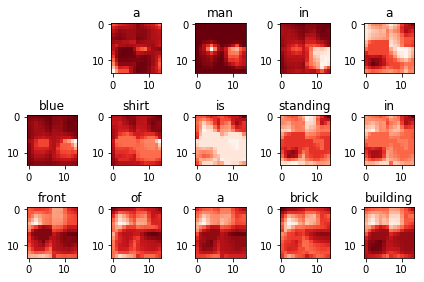

In [235]:
target_idx = 15
print(' '.join(recon_captions[target_idx][1:-1]))
caption = recon_captions[target_idx]
for t in range(1, image_alphas[target_idx].shape[0]-1):
    if t > 14:
        break
    alpha = image_alphas[target_idx][t, :] * 255.
    plt.subplot(np.ceil(image_alphas[target_idx].shape[1] / 5.), 5, t + 1)
    plt.imshow(alpha.reshape(14, 14))
    plt.set_cmap(cm.Reds_r)
    plt.title(caption[t])
plt.tight_layout()

zwei kinder spielen auf einer wiese .


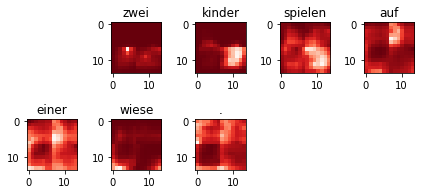

In [236]:
print(' '.join(de_recon_captions[target_idx][1:-1]))
caption = de_recon_captions[target_idx]
for t in range(1, de_image_alphas[target_idx].shape[0]-1):
    if t > 14:
        break
    alpha = de_image_alphas[target_idx][t, :] * 255.
    plt.subplot(np.ceil(de_image_alphas[target_idx].shape[1] / 5.), 5, t + 1)
    plt.imshow(alpha.reshape(14, 14))
    plt.set_cmap(cm.Reds_r)
    plt.title(caption[t])
plt.tight_layout()

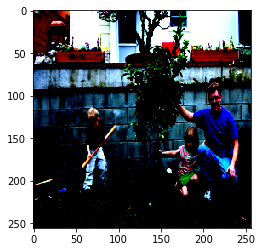

In [231]:
plt.imshow(X_images[target_idx, :].permute(1, 2, 0))

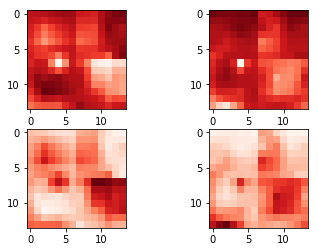

In [241]:
en_image_distr = image_alphas[target_idx].mean(0)
de_image_distr = de_image_alphas[target_idx].mean(0)
en_image_var = image_alphas[target_idx].std(0)
de_image_var = de_image_alphas[target_idx].std(0)
plt.subplot(2, 2, 1)
plt.imshow(en_image_distr)
plt.subplot(2, 2, 2)
plt.imshow(de_image_distr)
plt.subplot(2, 2, 3)
plt.imshow(en_image_var)
plt.subplot(2, 2, 4)
plt.imshow(de_image_var)s

In [238]:
from scipy.stats import entropy

In [239]:
entropy(en_image_distr.reshape(-1), de_image_distr.reshape(-1))

9.145405320954477e-05

In [277]:
d1 = np.random.normal(loc=0, size=(5, 14, 14)).reshape(5, -1)
d2 = np.random.normal(loc=0, size=(5, 14, 14)).reshape(5, -1)

In [278]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [279]:
pvals = [ttest_ind(d1[:, idx], d2[:, idx]).pvalue for idx in range(d1.shape[1])]
rejects, pvals_corrected, sidax_alpha, bonferonni_alpha = \
    multipletests(pvals, alpha=0.01)

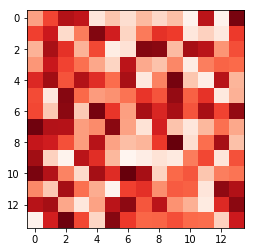

In [280]:
plt.imshow(np.array(pvals).reshape(14, 14))

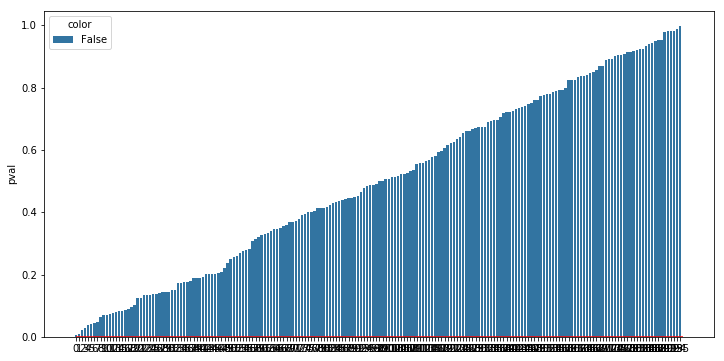

In [327]:
import seaborn as sns
plt.figure(figsize=(12, 6))
df = pd.DataFrame({"pval":pvals, "item": np.arange(len(pvals))})
df = df.sort_values(["pval"]).reset_index(drop=True)
df["color"] = df.pval < bonferonni_alpha
sns.barplot(df.index, df.pval, hue=df.color)
plt.gca().hlines(bonferonni_alpha, xmin=0, xmax=196, color="red")
# ax = plt.gca()
# ax.hlines(bonferonni_alpha, xmin=0, xmax=196, color="red")